In [91]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import fitsio
from astrometry.util.fits import fits_table, merge_tables
from glob import glob

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
from obiwan.common import fits2pandas

In [267]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
dr3_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/decals-dr3.1-deep2-field*-trim.fits'))
dp2_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/deep2-field*-trim.fits'))                                                               
dr3_fns,dp2_fns

(['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits',
  '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits',
  '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits'],
 ['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field2-trim.fits',
  '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field3-trim.fits',
  '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field4-trim.fits'])

In [272]:
def stack_tables(fns):
    cat=[]
    assert(len(fns) > 0)
    for fn in fns:
        assert(os.path.exists(fn))
        print('Stacking %s' % fn)
        cat.append( fits_table(fn) )
    return merge_tables(cat, columns='fillzero')

dr3= stack_tables(dr3_fns)
dp2= stack_tables(dp2_fns)
len(dr3),len(dp2)

Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field2-trim.fits
Converted source from |S12 to <U12
Converted vis_morph from |S1 to <U1
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field3-trim.fits
Converted source from |S12 to <U12
Converted vis_morph from |S1 to <U1
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field4-trim.fits
Converted source from |S12 to <U12
Converted vis_morph from |S1 to <U1


(28284, 28284)

In [273]:
dr3.get_columns(), dp2.get_columns()

(['brickid',
  'brickname',
  'objid',
  'type',
  'ra',
  'ra_ivar',
  'dec',
  'dec_ivar',
  'decam_flux',
  'decam_flux_ivar',
  'decam_mw_transmission',
  'decam_nobs',
  'decam_rchi2',
  'decam_psfsize',
  'decam_fracflux',
  'decam_fracmasked',
  'decam_fracin',
  'decam_depth',
  'decam_galdepth',
  'out_of_bounds',
  'decam_anymask',
  'decam_allmask',
  'wise_flux',
  'wise_flux_ivar',
  'wise_mw_transmission',
  'wise_nobs',
  'wise_fracflux',
  'wise_rchi2',
  'dchisq',
  'fracdev',
  'tycho2inblob',
  'shapedev_r',
  'shapedev_r_ivar',
  'shapedev_e1',
  'shapedev_e1_ivar',
  'shapedev_e2',
  'shapedev_e2_ivar',
  'shapeexp_r',
  'shapeexp_r_ivar',
  'shapeexp_e1',
  'shapeexp_e1_ivar',
  'shapeexp_e2',
  'shapeexp_e2_ivar',
  'ebv'],
 ['field',
  'subfield',
  'objno',
  'ra',
  'dec',
  'b',
  'r',
  'i',
  'berr',
  'rerr',
  'ierr',
  'pgal',
  'rg',
  'badflag',
  'zhelio',
  'zhelio_err',
  'zquality',
  'sfd_ebv',
  'source',
  'mask_weight',
  'obj_weight',
  'selec

In [274]:
grz_gt0= (np.all(dr3.decam_flux[:,[1,2,4]] > 0,axis=1) &
          np.all(dr3.decam_flux_ivar[:,[1,2,4]] > 0,axis=1))
len(dr3[grz_gt0])

27433

In [277]:
#keep= ((dp2.zhelio >= 0.6) &
#       (dp2.zhelio <= 1.7) &
keep=  ((dp2.oii_3727 >= 0.) &
        (dp2.oii_3727_err > 0.)
      )
len(dp2[keep]),dp2[keep].zhelio.min(),dp2[keep].zhelio.max()

(17131, 0.69759357, 1.4767396)

In [278]:
len(dr3[keep & grz_gt0])

16639

In [279]:
dr3.cut(keep & grz_gt0)
dp2.cut(keep & grz_gt0)

In [280]:
set(dr3.type)

{'COMP', 'DEV', 'EXP', 'PSF', 'SIMP'}

In [281]:
isCOMP= dr3.type == 'COMP'
print('# COMP=%d, # ALL=%d' % (len(dr3[isCOMP]),len(dr3)))
assert(float(len(dr3[isCOMP]))/len(dr3) < 0.01)
dr3.cut(isCOMP == False)
dp2.cut(isCOMP == False)

fwhm_or_rhalf= np.zeros(len(dr3))-1 # arcsec
isPSF= dr3.type == 'PSF'
isEXP= dr3.type == 'EXP'
isSIMP= dr3.type == 'SIMP'
isDEV= dr3.type == 'DEV'
fwhm_or_rhalf[isPSF]= np.mean(dr3[isPSF].decam_psfsize[:,[1,2,4]],axis=1)
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= dr3[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= dr3[isDEV].shapedev_r

# COMP=45, # ALL=16639


In [282]:
def flux2mag(nmgy):
    return -2.5 * (np.log10(nmgy) - 9)

def deredden_flux_ivar(flux_ivar,ext):
    return flux_ivar * np.power(ext,2)

In [283]:
d= {}
for i,b in zip([1,2,4],'grz'):
    d[b]= flux2mag(dr3.get('decam_flux')[:,i]/dr3.get('decam_mw_transmission')[:,i])
    #d[b+'_ivar']= flux2mag(dr3.get('decam_flux_ivar')[:,i]/dr3.get('decam_mw_transmission')[:,i])
d['redshift']= dp2.get('zhelio')
d['fwhm_or_rhalf']= fwhm_or_rhalf
d['type']= dr3.get('type')
d['oii']= dp2.oii_3727
df= pd.DataFrame(d)

# What is fraction EXP versus DEV?

In [284]:
df['type'].value_counts()/len(df)

PSF     0.391587
SIMP    0.360130
EXP     0.209895
DEV     0.038387
Name: type, dtype: float64

# Plots

In [285]:
df.describe()

,fwhm_or_rhalf,g,oii,r,redshift,z
count,16594.000000,16594.000000,1.659400e+04,16594.000000,16594.000000,16594.000000
mean,0.910553,24.221848,1.030666e-16,23.420313,1.003967,22.355127
std,0.935227,0.925690,4.848181e-16,0.674674,0.183475,0.847277
min,0.157800,20.680729,1.013979e-20,19.884142,0.697594,18.510616
25%,0.500000,23.674767,4.159124e-17,23.012117,0.849887,21.812612
50%,0.700325,24.154682,7.177630e-17,23.491629,0.971703,22.421124
75%,1.291301,24.645355,1.138218e-16,23.899687,1.135955,22.944411
max,72.294441,33.059296,4.393579e-14,30.612267,1.476740,28.587051


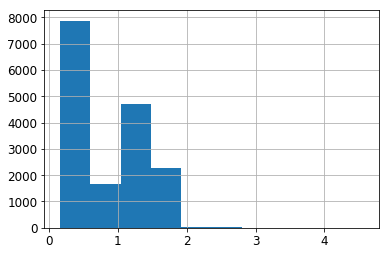

In [286]:
df.loc[df['fwhm_or_rhalf'] < 5.,'fwhm_or_rhalf'].hist()

In [287]:
df= df[df['fwhm_or_rhalf'] < 5.]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d8efc50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124d6a828>]], dtype=object)

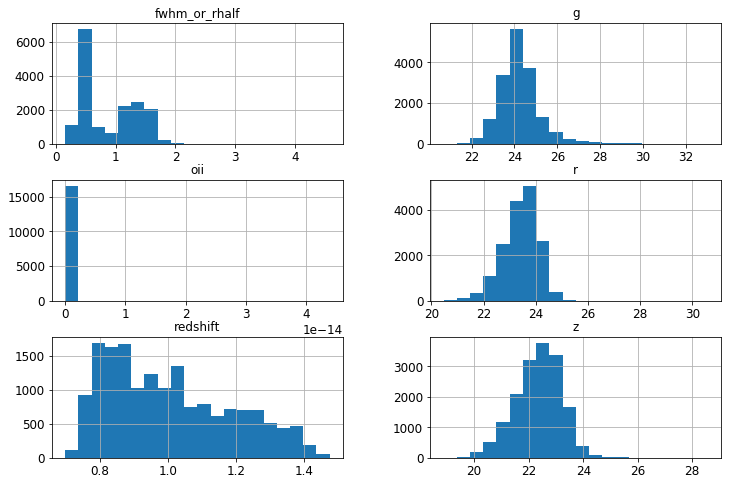

In [288]:
df.hist(bins=20,figsize=(12,8))

(array([  3.00000000e+00,   1.00000000e+01,   3.30000000e+01,
          8.50000000e+01,   1.52000000e+03,   9.48100000e+03,
          5.26300000e+03,   1.65000000e+02,   2.20000000e+01,
          3.00000000e+00]),
 array([-19.99397087, -19.33029194, -18.66661301, -18.00293407,
        -17.33925514, -16.67557621, -16.01189728, -15.34821835,
        -14.68453941, -14.02086048, -13.35718155]),
 <a list of 10 Patch objects>)

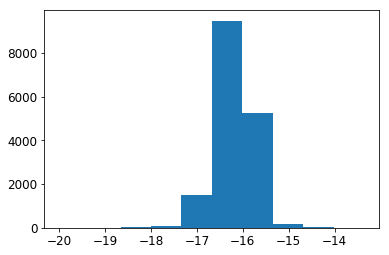

In [289]:
plt.hist(np.log10(df['oii']))

(-0.6, 2.2)

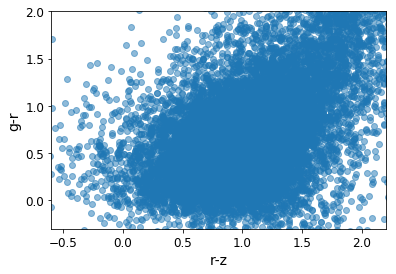

In [290]:
plt.scatter(df['r'] - df['z'],df['g'] - df['r'],alpha=0.5)
plt.xlabel('r-z')
plt.ylabel('g-r')
plt.ylim(-0.3,2)
plt.xlim(-0.6,2.2)

(-0.6, 2.2)

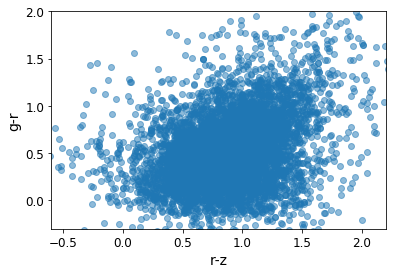

In [291]:
hiO2= df['oii'] > 8.e-17
plt.scatter((df['r'] - df['z'])[hiO2],(df['g'] - df['r'])[hiO2],alpha=0.5)
plt.xlabel('r-z')
plt.ylabel('g-r')
plt.ylim(-0.3,2)
plt.xlim(-0.6,2.2)

In [292]:
df.columns

Index(['fwhm_or_rhalf', 'g', 'oii', 'r', 'redshift', 'type', 'z'], dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125a93208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x125a93400>]], dtype=object)

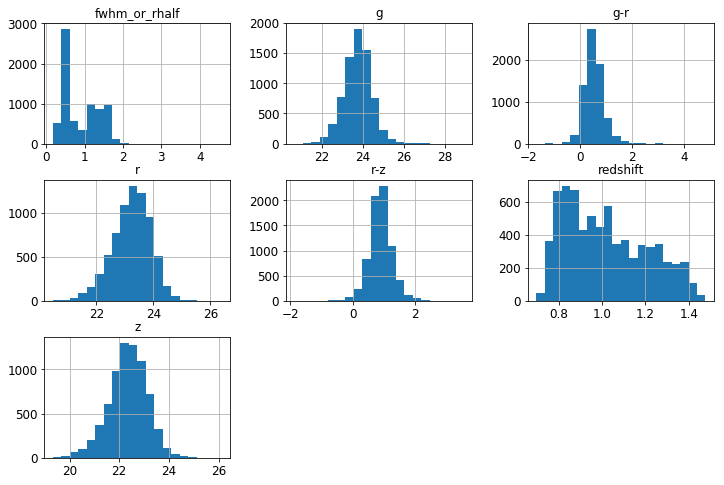

In [293]:
cols=['fwhm_or_rhalf', 'g', 'r', 'redshift', 'z']
df_new= df.loc[hiO2,cols]
df_new['g-r']= df_new['g'] - df_new['r']
df_new['r-z']= df_new['r'] - df_new['z']
df_new.hist(bins=20,figsize=(12,8))

In [294]:
# MoG fit
def my_mixture(X):
    # Compute density via Gaussian Mixtures
    # we'll try several numbers of clusters
    n_components = np.arange(3, 16)
    gmms = [mixture.GaussianMixture(n_components=n).fit(X) 
            for n in n_components]
    BICs = [gmm.bic(X)/X.shape[0] for gmm in gmms]
    i_min = np.argmin(BICs)
    print("%d components" % n_components[i_min])
    return gmms[i_min], n_components, BICs

In [ ]:
mixture.GaussianMixture?

In [178]:
np.argmin(np.arange(5,15))

0

In [295]:
X= df_new.loc[:,['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']].values
gmm, n_comp, BICs= my_mixture(X)
logprob= gmm.score_samples(X)
responsibilities = gmm.predict_proba(X)

15 components


In [296]:
Xpred,Ypred= gmm.sample(10000)
Xpred.shape

(10000, 5)

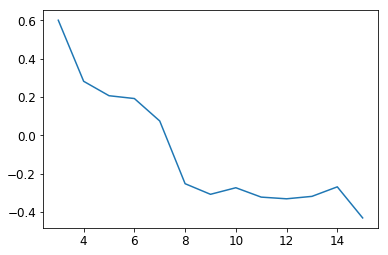

In [297]:
plt.plot(n_comp,BICs)

In [298]:
d={}
for i,col in enumerate(['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']):
    d[col]= Xpred[:,i]
df_pred= pd.DataFrame(d)

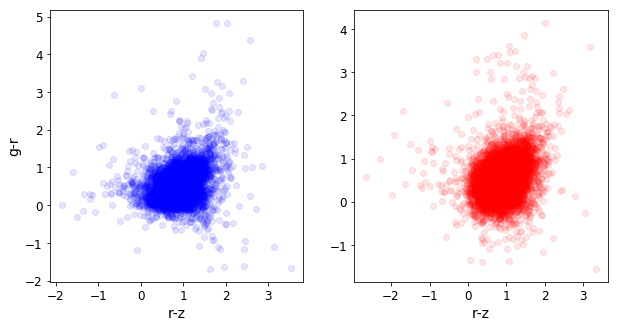

In [299]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['r-z'],df_new['g-r'],color='b',alpha=0.1)
ax[1].scatter(df_pred['r-z'],df_pred['g-r'],color='r',alpha=0.1)
for i in range(2):
    ax[i].set_xlabel('r-z')
ax[0].set_ylabel('g-r')

0.170597106218


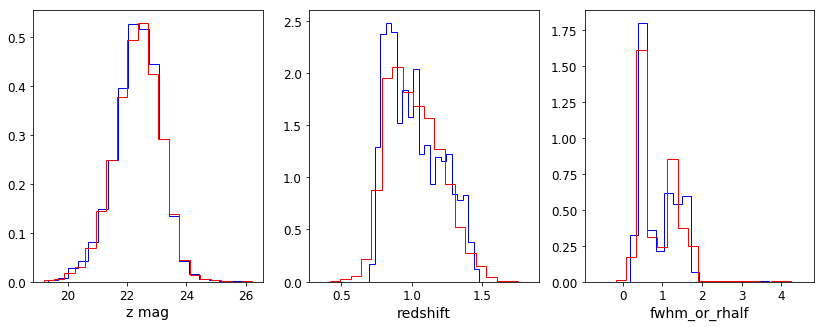

In [303]:
fig,ax= plt.subplots(1,3,figsize=(14,5))

_,bins,_= ax[0].hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0].hist(df_pred['z'],bins=20,histtype='step',color='r',normed=True)
ax[0].set_xlabel('z mag')

_,bins,_= ax[1].hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=ax[1].hist(df_pred['redshift'],bins=20,histtype='step',color='r',normed=True)
ax[1].set_xlabel('redshift')

_,bins,_= ax[2].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(df_pred['fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[2].set_xlabel('fwhm_or_rhalf')

print(df_new['fwhm_or_rhalf'].min())

In [263]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

In [264]:
gmm.means_.shape, gmm.covariances_.shape, gmm.weights_.shape

((14, 5), (14, 5, 5), (14,))

In [301]:
from scipy.stats import norm

def sum_gaussians(x,means,covs,wts):
    a= np.array([wt * norm.pdf(x,loc=mu,scale=var**0.5)
                 for mu,var,wt in zip(means,covs,wts)])
    print(a.shape)
    return np.sum(a,axis=0)

In [214]:
a=np.array([np.arange(10) for i in range(5)])
np.sum(a,axis=0)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

(15, 50)


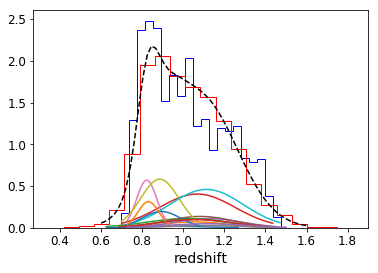

In [302]:
_=plt.hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=plt.hist(df_pred['redshift'],bins=20,histtype='step',color='r',normed=True)
plt.xlabel('redshift')

i=-1
for mu,var,wt in zip(gmm.means_[:,-1],gmm.covariances_[:,-1,-1],
                     gmm.weights_):
    x= np.linspace(mu-2*var**0.5,mu+2*var**0.5)
    plt.plot(x,wt * norm.pdf(x,loc=mu,scale=var**0.5))

x= np.linspace(0.6,1.6,num=50)
plt.plot(x,sum_gaussians(x,gmm.means_[:,-1],gmm.covariances_[:,-1,-1],
                         gmm.weights_),
         'k--')
# plt.plot(x,sum_gaussians(x,gmm.means_[:,-1],gmm.covariances_[:,-1,-1],
#                          new_wts),
#          'm--')

In [229]:
new_wts= [wt + norm.cdf(0.8,loc=mu,scale=var**0.5) + norm.cdf(1.4,loc=mu,scale=var**0.5)
          for mu,var,wt in zip(gmm.means_[:,-1],\
                               gmm.covariances_[:,-1,-1],\
                               gmm.weights_)]
new_wts= np.array(new_wts)/np.sum(new_wts)
# new_wts=[]
# for mu,var,wt in zip(gmm.means_[:,-1],
#                      gmm.covariances_[:,-1,-1],
#                      gmm.weights_):
#     new_wts.append(wt + norm.cdf(0.8,loc=mu,scale=var**0.5))

In [193]:
gmm.predict_proba

In [204]:
mu,std= gmm.means_[:,-1][-2], gmm.covariances_[:,-1,-1][-2]**0.5
#x= np.linspace(mu-2*std,mu+2*std)
print(mu,std)
norm.cdf(0.8,loc=mu,scale=std)

0.849718097071 0.0323725432247


0.062292411886041781

In [192]:
gmm.means_[:,-1][-2], gmm.weights_.sum()

(0.84971809707069645, 0.99999999999999956)

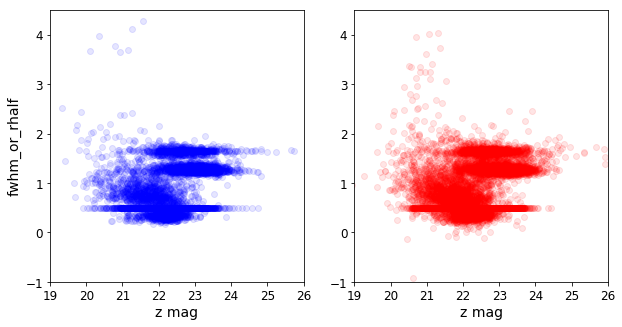

In [159]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['fwhm_or_rhalf'],color='b',alpha=0.1)
ax[1].scatter(df_pred['z'],df_pred['fwhm_or_rhalf'],color='r',alpha=0.1)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('fwhm_or_rhalf')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(-1,4.5)

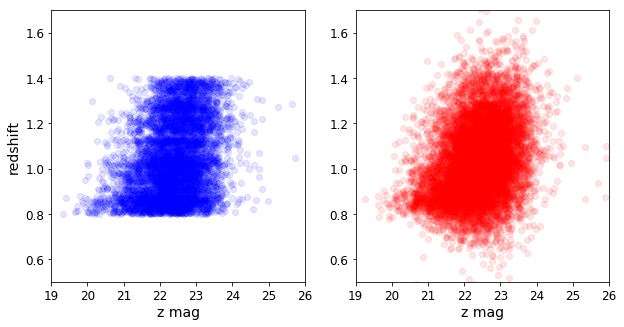

In [160]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['redshift'],color='b',alpha=0.1)
ax[1].scatter(df_pred['z'],df_pred['redshift'],color='r',alpha=0.1)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('redshift')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(0.5,1.7)

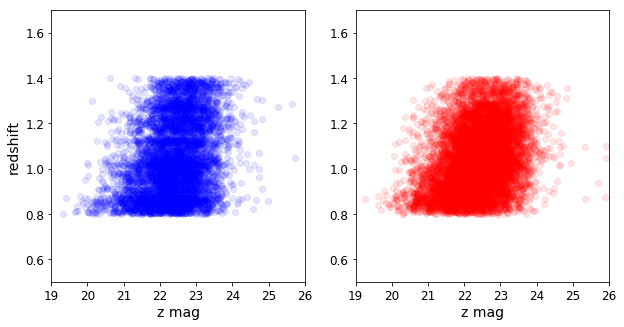

In [161]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['redshift'],color='b',alpha=0.1)
inRng= (df_pred['redshift'] >= 0.8) & (df_pred['redshift'] <= 1.4)
ax[1].scatter(df_pred.loc[inRng,'z'],df_pred.loc[inRng,'redshift'],color='r',alpha=0.1)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('redshift')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(0.5,1.7)

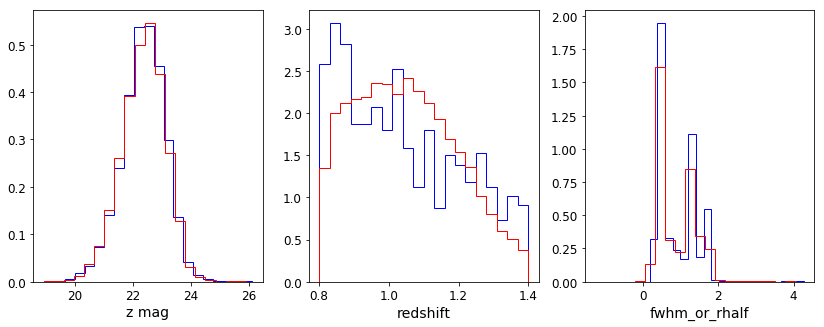

In [163]:
fig,ax= plt.subplots(1,3,figsize=(14,5))

_= ax[0].hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0].hist(df_pred.loc[inRng,'z'],bins=20,histtype='step',color='r',normed=True)
ax[0].set_xlabel('z mag')

_,bins,_= ax[1].hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=ax[1].hist(df_pred.loc[inRng,'redshift'],bins=20,histtype='step',color='r',normed=True)
ax[1].set_xlabel('redshift')

_,bins,_= ax[2].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(df_pred.loc[inRng,'fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[2].set_xlabel('fwhm_or_rhalf')


In [ ]:
fig,ax= plt.subplots()
_,bins,_= ax.hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax.hist(df_pred['z'],bins,histtype='step',color='r',normed=True)

# Draw a redshift from n(z), and select 15 component GMM instance with z closest to the z drawn

In [306]:
len(df_pred['redshift']),len(set(df_pred['redshift']))

(10000, 10000)

In [309]:
# ID={}
# for i,z in enumerate(df_pred['redshift']):
#     ID[str(z)]= i
# len(ID.keys())

10000

In [320]:
spatial.KDTree?

In [321]:
from scipy import spatial
tree = spatial.KDTree(df_pred['redshift'].values.reshape(-1,1))

In [337]:
_,ind= tree.query(np.linspace(0.8,1.4,num=100000).reshape(-1,1))
randoms= df_pred.loc[ind,:]
len(df_pred),len(ind),len(randoms)

(10000, 100000, 100000)

# DESI n(z): Sanchez & Kirby Mock

In [310]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
z_bins= np.loadtxt(os.path.join(DATA_DIR,'sanchez_kirkby_bins.txt'),
                   dtype=float)
pdf= np.loadtxt(os.path.join(DATA_DIR,'sanchez_kirkby_pdf.txt'),
                   dtype=float)
z_10k= fits_table(os.path.join(DATA_DIR,'sanchez_kirkby_z_rand10k.fits'))

In [32]:
z_bins,pdf

(array([ 0.37530702,  0.42530702,  0.47530702,  0.52530702,  0.57530702,
         0.62530702,  0.67530702,  0.72530702,  0.77530702,  0.82530702,
         0.87530702,  0.92530702,  0.97530702,  1.02530702,  1.07530702,
         1.12530702,  1.17530702,  1.22530702,  1.27530702,  1.32530702,
         1.37530702,  1.42530702,  1.47530702,  1.52530702,  1.57530702,
         1.62530702,  1.67530702,  1.72530702]),
 array([  5.97100000e-05,   1.50542000e-03,   1.76785300e-02,
          8.84732000e-02,   2.84925680e-01,   7.39386710e-01,
          1.34832717e+00,   1.67066185e+00,   1.67005896e+00,
          1.63804793e+00,   1.64072498e+00,   1.54290155e+00,
          1.34524606e+00,   1.19831291e+00,   1.13670714e+00,
          1.10855340e+00,   1.05699101e+00,   8.94507910e-01,
          6.31820920e-01,   4.59504660e-01,   3.94339850e-01,
          3.49333740e-01,   2.94378110e-01,   2.25234390e-01,
          1.48763210e-01,   8.26350600e-02,   3.09199400e-02]))

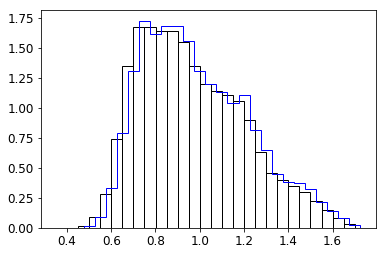

In [62]:
plt.bar(left=z_bins[:-1],height=pdf,width=z_bins[1]-z_bins[0],fill=False)
_=plt.hist(z_10k.z_cosmo,bins=z_bins,histtype='step',color='b',normed=True)


In [43]:
np.vstack([(z_bins[1:]+z_bins[:-1])/2,
           pdf]).T.shape

(27, 2)

In [7]:
mixture.GaussianMixture?

Object `mixture.GaussianMixture` not found.


In [51]:
from sklearn.mixture import GMM


In [64]:
z_10k.z_cosmo.reshape(-1,1).shape

(10000, 1)

(1000, 1)


/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/kaylan1/miniconda3/envs/mlbo

(array([   3.,    9.,   33.,   84.,  206.,  281.,  148.,   94.,  114.,   28.]),
 array([-5.58064657, -4.55094874, -3.52125091, -2.49155308, -1.46185526,
        -0.43215743,  0.5975404 ,  1.62723823,  2.65693606,  3.68663389,
         4.71633172]),
 <a list of 10 Patch objects>)

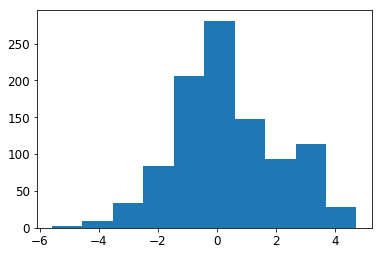

In [57]:
np.random.seed(1)

gmm = GMM(3, n_iter=1)
gmm.means_ = np.array([[-1], [0], [3]])
gmm.covars_ = np.array([[1.5], [1], [0.5]]) ** 2
gmm.weights_ = np.array([0.3, 0.5, 0.2])

X = gmm.sample(1000)
print(X.shape)
plt.hist(X)

In [58]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

In [67]:
X= z_10k.z_cosmo.reshape(-1,1)

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]




for i in range(len(N)):
    # Fit a Gaussian mixture with EM
    GMM = mixture.GaussianMixture(n_components=in_components,
                                  covariance_type=cv_type)
    GMM.fit(X)
    bic.append(GMM.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
    
    models[i] = GMM(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(5, 1.7))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(-6, 6, 1000)
logprob, responsibilities = M_best.eval(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)

ValueError: Invalid value for 'n_components': 0 Estimation requires at least one component

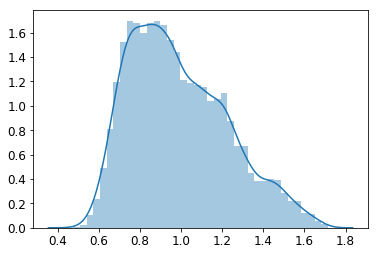

In [108]:
sns.distplot(pd.Series(z_10k.z_cosmo))

(array([ 1060.,   878.,   738.,   811.,   508.,   503.,   541.,   508.,
          348.,   361.]),
 array([ 0.80016702,  0.86012283,  0.92007864,  0.98003444,  1.03999025,
         1.09994605,  1.15990186,  1.21985766,  1.27981347,  1.33976927,
         1.39972508]),
 <a list of 10 Patch objects>)

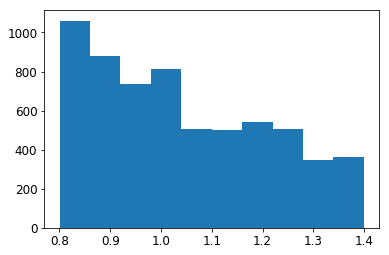

In [142]:
hiO2= df['oii'] > 8.e-17
plt.hist(df.loc[hiO2,'redshift'])

In [143]:
# Table 2.3 DESI Science Part 1
dN_dz_ddeg= np.array([309,2269,1923,2094,1441,1353,1337,523,466,329,126,0,0])
z= np.linspace(0.65,1.85,num=len(dN_dz_ddeg))
bin_width= z[1]-z[0]
zbins= np.linspace(z[0]-bin_width/2.,z[-1]+bin_width/2,num=len(z)+1)
len(dN_dz_ddeg),len(z),z,zbins

(13, 13, array([ 0.65,  0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,
         1.55,  1.65,  1.75,  1.85]), array([ 0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,
         1.7,  1.8,  1.9]))

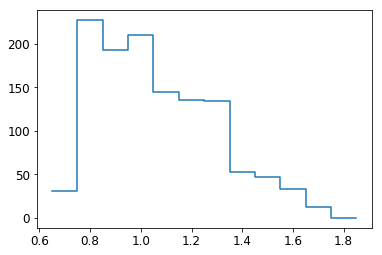

In [144]:
plt.step(z,dN_dz_ddeg/10,where='post')

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,
         1.7,  1.8,  1.9]),
 <a list of 1 Patch objects>)

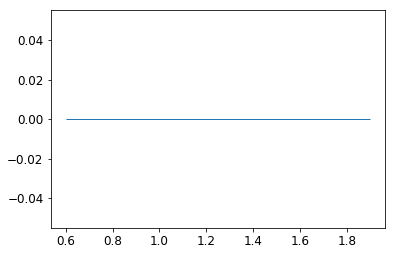

In [116]:
plt.hist(dN_dz_ddeg,bins=zbins,histtype='step')

In [117]:
plt.step?

# Example
#### http://www.astroml.org/book_figures/chapter6/fig_GMM_density_estimation.html

In [24]:
from sklearn.mixture import GMM

Object `GMM.eval` not found.


In [25]:
gmm.predict?

Object `gmm.predict` not found.


In [9]:
from sklearn import mixture
mixture.GaussianMixture?

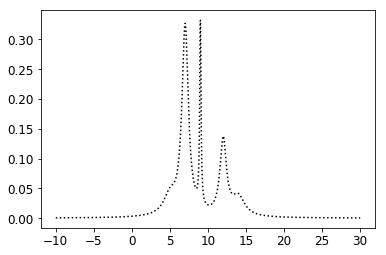

In [17]:
plt.plot(t.reshape(-1,1), true_pdf(t).reshape(-1,1), 
        ':', color='black', zorder=3,
        label="Generating Distribution")
#plt.show()

In [27]:
gmm=gmms[0]
gmm.predict?

(1000, 1) (1000, 1)
(500, 1)
(1000, 1)
(1000, 1) (1000, 1)
(5000, 1)
(1000, 1)


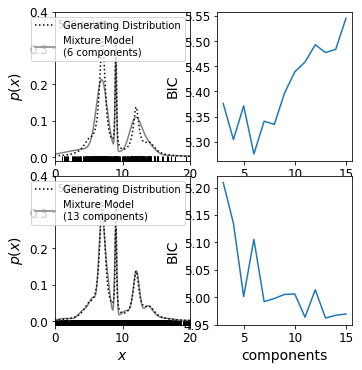

In [121]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f]).reshape(-1,1)
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])

np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]


#plt.show()
#------------------------------------------------------------
# plot the results
N_values = (500, 5000)
subplots = (221, 223)

for N, subplot in zip(N_values, subplots):
    ax = fig.add_subplot(subplot)
    
    t = np.linspace(-10, 30, 1000).reshape(-1,1)
    print(t.shape,true_pdf(t).shape)
    ax.plot(t.reshape(-1,1), true_pdf(t).reshape(-1,1), 
            ':', color='black', zorder=3,
            label="Generating Distribution")

    xN = x[:N].reshape(-1,1)
    print(xN.shape)
    # Compute density via Gaussian Mixtures
    # we'll try several numbers of clusters
    n_components = np.arange(3, 16)
    gmms = [mixture.GaussianMixture(n_components=n).fit(xN) 
            for n in n_components]
    BICs = [gmm.bic(xN)/xN.shape[0] for gmm in gmms]    
    
    i_min = np.argmin(BICs)
    print(t.shape)
    logprob= gmms[i_min].score_samples(t)
    responsibilities = gmms[i_min].predict_proba(t)

    # plot the results
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k', lw=1.5)
    ax.plot(t, np.exp(logprob), '-', color='gray',
            label="Mixture Model\n(%i components)" % n_components[i_min])

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 223:
        ax.set_xlabel('$x$')
    if subplot == 221:
        ax2 = fig.add_subplot(222)
    else: 
        ax2 = fig.add_subplot(224)
    ax2.plot(n_components,BICs)
    ax2.set_xlabel('components')
    ax2.set_ylabel('BIC')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

In [59]:
bins.shape,h.shape

((24,), (25,))

In [62]:
np.histogram?

(24,) (25,) (1000,)


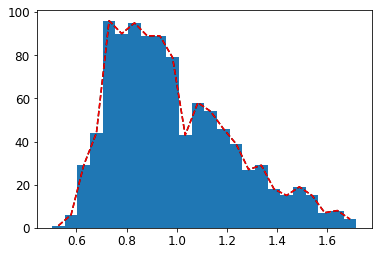

In [70]:
X= z_10k.z_cosmo[:1000]
h,bins,_=plt.hist(X,bins=np.linspace(X.min(),X.max(),num=25))
plt.plot((bins[1:]+bins[:-1])/2,h,'k--')
h,bins= np.histogram(X,bins)
plt.plot((bins[1:]+bins[:-1])/2,h,'r--')
print(h.shape,bins.shape,X.shape)

In [311]:
def my_mixture(X):
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

    N_values = (5000,10000)
    subplots = (221, 223)


    t = np.linspace(X.min(),X.max(),num=25)
    print(X.shape,t.shape)
    pdf,bins= np.histogram(X,t,normed=True)
    t= t.reshape(-1,1)

    for N, subplot in zip(N_values, subplots):
        ax = fig.add_subplot(subplot)

        ax.plot((t[1:]+t[:-1])/2,pdf,'k:',
                label="Generating Distribution")

        xN = z_10k.z_cosmo[:N].reshape(-1,1)
        print(xN.shape)
        # Compute density via Gaussian Mixtures
        # we'll try several numbers of clusters
        n_components = np.arange(3, 16)
        gmms = [mixture.GaussianMixture(n_components=n).fit(xN) 
                for n in n_components]
        BICs = [gmm.bic(xN)/xN.shape[0] for gmm in gmms]
        i_min = np.argmin(BICs)
        print(t.shape)
        logprob= gmms[i_min].score_samples(t)
        responsibilities = gmms[i_min].predict_proba(t)

        # plot the results
        ax.plot(xN, -0.005 * np.ones(len(xN)), '|k', lw=1.5)
        ax.plot(t, np.exp(logprob), '-', color='gray',
                label="Mixture Model\n(%i components)" % n_components[i_min])

        # label the plot
        ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
                transform=ax.transAxes)
        ax.set_ylabel('$p(x)$')
        #ax.legend(loc='upper right')

        if subplot == 222:
            ax.set_xlabel('$x$')
        if subplot == 221:
            ax2 = fig.add_subplot(222)
        else: 
            ax2 = fig.add_subplot(224)
        ax2.plot(n_components,BICs)
        ax2.set_xlabel('components')
        ax2.set_ylabel('BIC')


        #ax.set_xlim(0, 20)
        #ax.set_ylim(-0.01, 0.4001)

    plt.show()

(10000,) (25,)
(5000, 1)
(25, 1)
(10000, 1)
(25, 1)


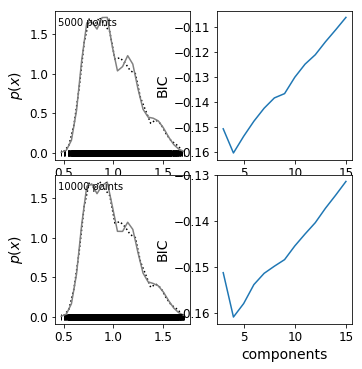

In [312]:
my_mixture(z_10k.z_cosmo)

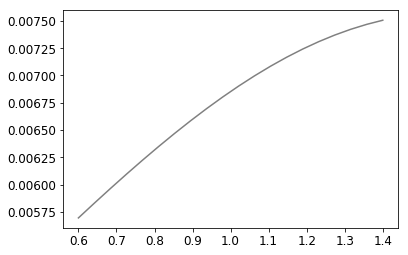

In [316]:
# Repeat for full Sanchez & Kirkby dataset
t= np.linspace(0.6,1.4,num=20)
logprob= gmms[i_min].score_samples(t.reshape(-1,1))
plt.plot(t, np.exp(logprob), '-', color='gray')

In [317]:
gmm= gmms[i_min]
X,y= gmm.sample(10000)

(array([  1.30000000e+01,   4.90000000e+01,   1.50000000e+02,
          1.28000000e+03,   5.48900000e+03,   2.46000000e+03,
          4.43000000e+02,   7.50000000e+01,   3.90000000e+01,
          2.00000000e+00]),
 array([-11.08121774,  -6.83073841,  -2.58025908,   1.67022025,
          5.92069958,  10.17117891,  14.42165824,  18.67213757,
         22.9226169 ,  27.17309623,  31.42357556]),
 <a list of 10 Patch objects>)

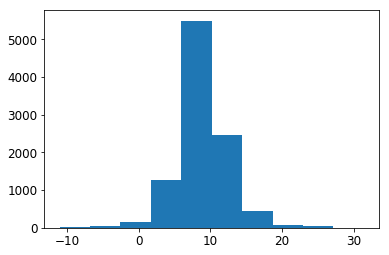

In [318]:
plt.hist(X)